In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from rdkit import Chem

df_b3db_kc = pd.read_csv("b3db_kc_split_descriptors.tsv", sep="\t")
df_train = df_b3db_kc[df_b3db_kc.split == "training"].copy().reset_index(drop=True)

In [2]:
[z for z in list(df_b3db_kc) if "Num" in z] 

['desc2D_NumValenceElectrons',
 'desc2D_NumRadicalElectrons',
 'desc2D_NumAliphaticCarbocycles',
 'desc2D_NumAliphaticHeterocycles',
 'desc2D_NumAliphaticRings',
 'desc2D_NumAromaticCarbocycles',
 'desc2D_NumAromaticHeterocycles',
 'desc2D_NumAromaticRings',
 'desc2D_NumHAcceptors',
 'desc2D_NumHDonors',
 'desc2D_NumHeteroatoms',
 'desc2D_NumRotatableBonds',
 'desc2D_NumSaturatedCarbocycles',
 'desc2D_NumSaturatedHeterocycles',
 'desc2D_NumSaturatedRings',
 'desc2D_NumAtomStereoCenters',
 'desc2D_NumUnspecifiedAtomStereoCenters',
 'desc2D_NumBridgeheadAtoms',
 'desc2D_NumAmideBonds',
 'desc2D_NumSpiroAtoms']

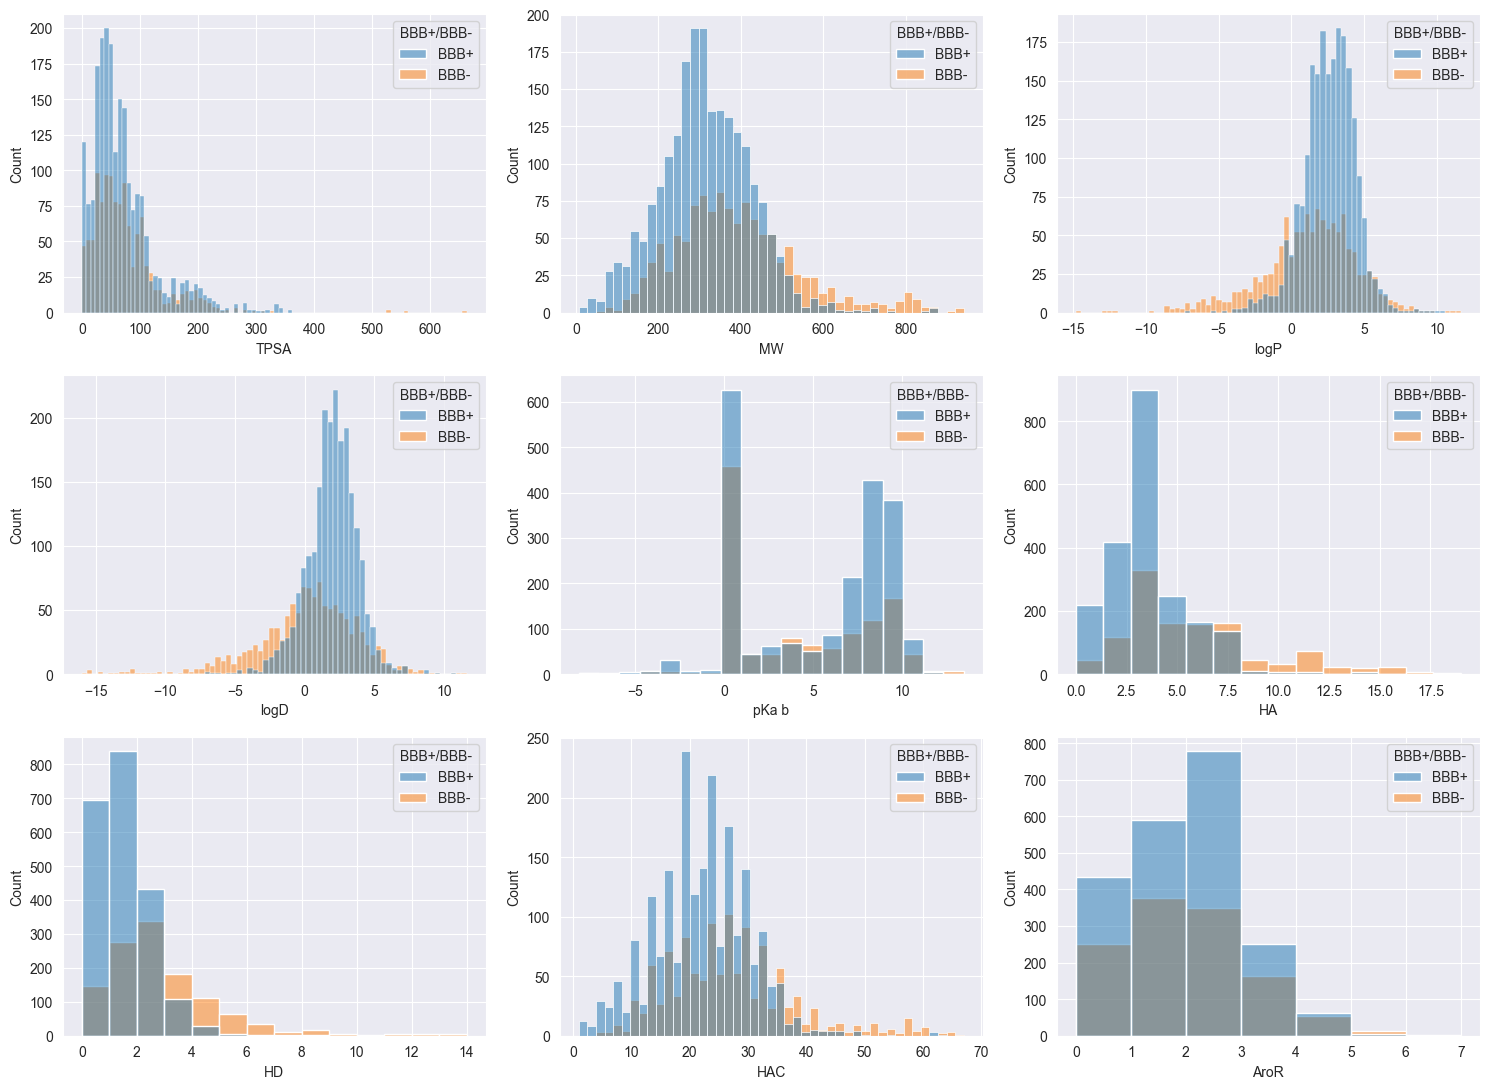

In [18]:
features_of_interest = [
    'desc2D_TPSA',
    'desc2D_MolWt',
    'chemaxon_logp',
    'chemaxon_logd',
    'chemaxon_pka_b',
    'desc2D_NumHAcceptors',
    'desc2D_NumHDonors',
    'desc2D_HeavyAtomCount',
    'desc2D_NumAromaticRings', # for this analysis only
    
    #'desc2D_MinAbsPartialCharge',
    #'desc2D_MaxEStateIndex',
    #'desc2D_MinEStateIndex',
    # 'desc2D_MinPartialCharge',
    # 'desc2D_MaxAbsPartialCharge',
    # 'desc2D_AvgIpc',
    # 'desc2D_HallKierAlpha',
    # 'desc2D_qed',
    # 'desc2D_MinAbsEStateIndex',
    # 'desc2D_NumRotatableBonds',
    # 'desc2D_FractionCSP3',
    # 'desc2D_BalabanJ',
    # 'desc2D_NumSaturatedRings',
    # 'desc2D_NumAliphaticHeterocycles',
    # 'desc2D_NumAliphaticCarbocycles',
    # 'desc2D_NumSpiroAtoms',
    # 'desc2D_NumBridgeheadAtoms',
    # 'desc2D_NumUnspecifiedAtomStereoCenters',
    # 'desc2D_NumAtomStereoCenters',
    # 'desc2D_NumRadicalElectrons',
    # 'desc2D_NumAmideBonds',
    #'desc2D_SPS'
]

f_rename_dict = {
    'desc2D_TPSA': "TPSA",
    'desc2D_MolWt': "MW",
    'chemaxon_logp': "logP",
    'chemaxon_logd': "logD",
    'chemaxon_pka_b': "pKa b",
    'desc2D_NumHAcceptors': "HA",
    'desc2D_NumHDonors': "HD",
    'desc2D_HeavyAtomCount': "HAC",
    'desc2D_NumAromaticRings': "AroR",
}
df_b3db_foi = df_b3db_kc[features_of_interest + ['BBB+/BBB-']].rename(columns=f_rename_dict)

n_cols = 3
n_rows = len(features_of_interest) // n_cols + (len(features_of_interest) % n_cols > 0)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 11), sharex=False, sharey=False)

# Plot each feature's density on a grid
for i, feature in enumerate(features_of_interest):
    row, col = divmod(i, n_cols)
    sns.histplot(data=df_b3db_foi, x=f_rename_dict[feature], hue='BBB+/BBB-', fill=True, ax=axes[row, col], bins=  14 if f_rename_dict[feature] in {"HA", "HD"} else 7 if f_rename_dict[feature] == "AroR"  else "auto")
    #axes[row, col].set_title(f'{feature.split("_", 1)[-1]}')

plt.tight_layout()
# Remove empty subplots if any
for i in range(len(features_of_interest), n_rows * n_cols):
    fig.delaxes(axes.flatten()[i])

# Plot the correlation matrix

#sns.pairplot(df_b3db_kc[ features_of_interest + ['BBB+/BBB-']], hue='BBB+/BBB-', markers=["o", "s"])

Text(0.0, 1.0, 'Correlation Matrix')

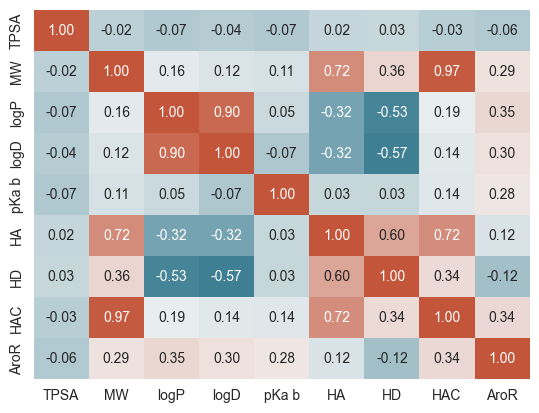

In [19]:
corr_matrix = _df.drop(columns=["BBB+/BBB-"]).corr()
cmap = sns.diverging_palette(220, 20, as_cmap=True)
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap=cmap, cbar=False )
axes[-1, 0].set_title('Correlation Matrix', loc='left', fontsize=14)

In [34]:
import rdkit
from rdkit.Chem import rdMolDescriptors
limited_features_of_interest = ["TPSA", "MW", "HA", "HD", "HAC", "AroR"]
df_b3db = pd.read_csv("../data/B3DB/B3DB/B3DB_classification.tsv", sep="\t")
df_b3db["mol"] = df_b3db["SMILES"].apply(lambda x: rdkit.Chem.MolFromSmiles(x))
df_b3db["TPSA"] = df_b3db.mol.apply(rdMolDescriptors.CalcTPSA)
df_b3db["MW"] = df_b3db.mol.apply(rdMolDescriptors.CalcExactMolWt)
df_b3db["HA"] = df_b3db.mol.apply(rdMolDescriptors.CalcNumHBA)
df_b3db["HD"] = df_b3db.mol.apply(rdMolDescriptors.CalcNumHBD)
df_b3db["HAC"] = df_b3db.mol.apply(rdMolDescriptors.CalcNumHeavyAtoms)
df_b3db["AroR"] = df_b3db.mol.apply(rdMolDescriptors.CalcNumAromaticRings)
df_b3db_foi["source"] = "B3DB_KC"
df_b3db["source"] = "B3DB"
_df = pd.concat([
    df_b3db_foi[limited_features_of_interest + ["BBB+/BBB-", "source"]],
    df_b3db[limited_features_of_interest + ["BBB+/BBB-", "source"]]
], axis=0)
_df[["BBB+/BBB-", "source"]].value_counts()
#_df.head()

BBB+/BBB-  source 
BBB+       B3DB       4956
BBB-       B3DB       2851
BBB+       B3DB_KC    2115
BBB-       B3DB_KC    1207
Name: count, dtype: int64

TypeError: matplotlib.font_manager.FontProperties() argument after ** must be a mapping, not int

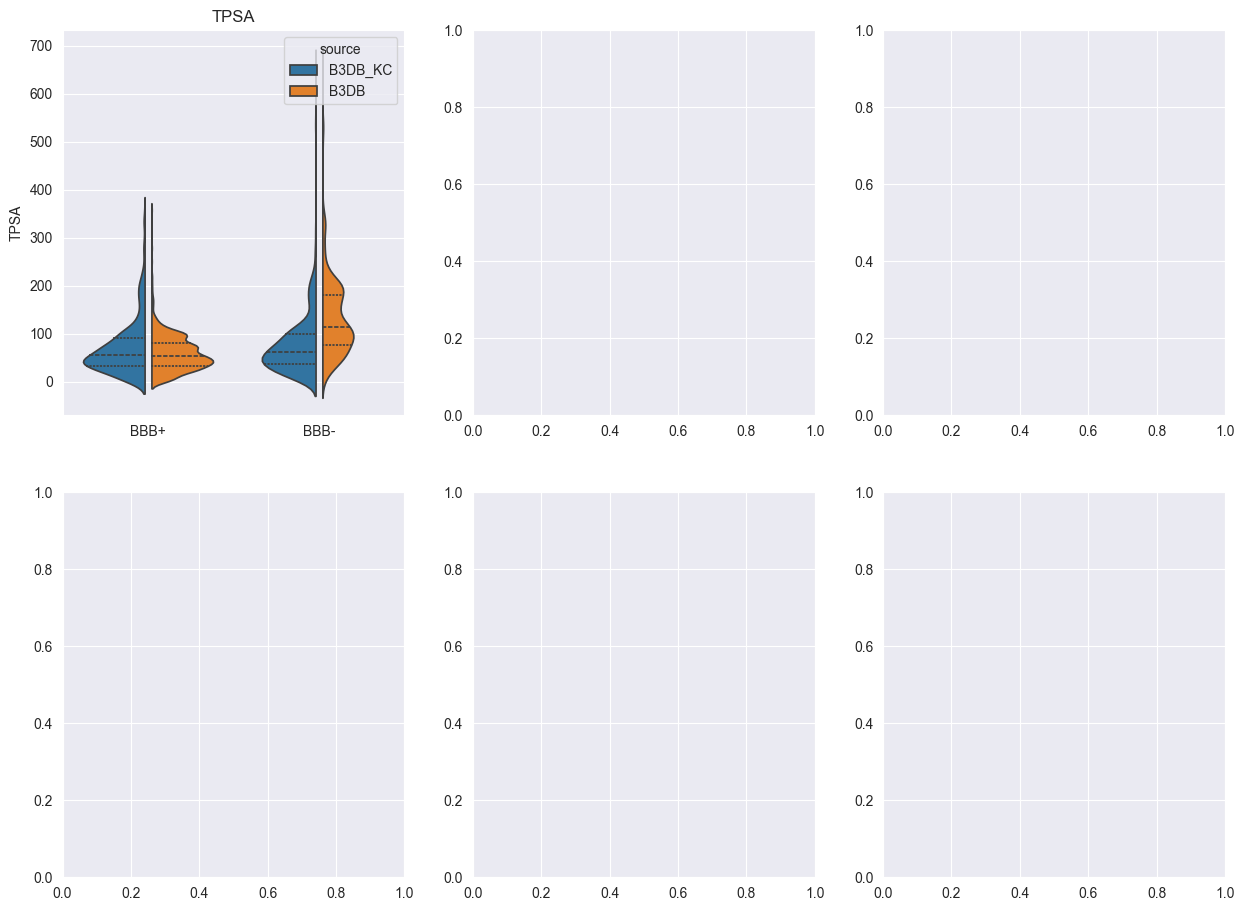

In [61]:
n_cols = 3
n_rows = len(limited_features_of_interest) // n_cols + (len(limited_features_of_interest) % n_cols > 0)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 11), sharex=False, sharey=False)


for i, f in enumerate(limited_features_of_interest):
    row, col = divmod(i, n_cols)
    
    sns.violinplot(data=_df[[f, "BBB+/BBB-", "source"]], ax=axes[row, col], y=f , x="BBB+/BBB-", hue="source", gap=0.1, split=True, inner="quart")
    axes[row, col].set_xlabel("")
    axes[row, col].set_title(f, font_size=12)
    

#plt.tight_layout()

for i in range(len(features_of_interest), n_rows * n_cols):
    fig.delaxes(axes.flatten()[i])
    
#sns.violinplot(_df)